In [ ]:
!pip install lightkurve

     |████████████████████████████████| 245 kB 4.1 MB/s 
     |████████████████████████████████| 98 kB 5.9 MB/s 
     |████████████████████████████████| 22.3 MB 1.6 MB/s 
     |████████████████████████████████| 41 kB 161 kB/s 
     |████████████████████████████████| 4.4 MB 41.2 MB/s 
     |████████████████████████████████| 802 kB 16.5 MB/s 
     |████████████████████████████████| 54 kB 2.1 MB/s 
     |████████████████████████████████| 3.2 MB 38.0 MB/s 
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11376 sha256=10c67c809cce8a1ae8e0d1d75d5c250de5d1353cb2fab85bc3cfe21c6d22aeb9
  Stored in directory: /root/.cache/pip/wheels/93/08/0c/1b9866c35c8d3f136d100dfe88036a32e0795437daca089f70
  Created wheel for memoization: filename=memoization-0.4.0-py3-none-any.whl size=50466 sha256=d45e5ac19b443291f37fcdf6d349c865cd04564f53e28fe7f4f59d4b30384b36
  Stored in directory: /root/.cache/pip/wheels/38/f7/65/161985e7311dd484a23b3a5c9149995dbf11db6cede602e7ef
  Created wheel for okt

In [ ]:
!pip install exoplanet

     |████████████████████████████████| 41 kB 79 kB/s 
     |████████████████████████████████| 211 kB 6.5 MB/s 


In [ ]:
import exoplanet

exoplanet.utils.docs_setup()
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

exoplanet.__version__ = '0.5.1'


/usr/local/lib/python3.7/dist-packages/lightkurve/search.py:352: LightkurveWarning: Warning: 3 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning,


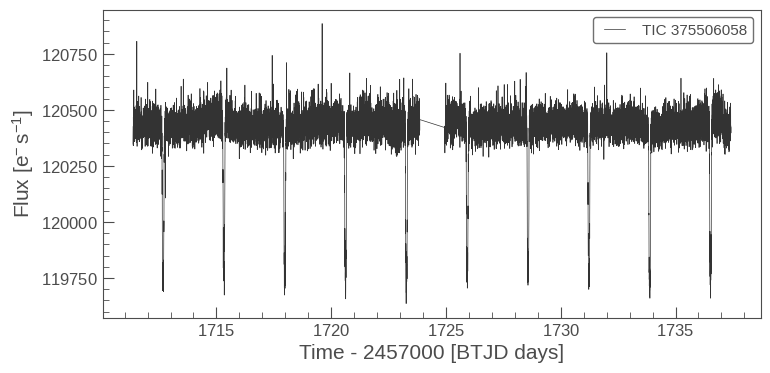

In [ ]:
lc = lk.search_lightcurve('TIC 375506058', mission="TESS", sector=15).download()
lc.plot();

/usr/local/lib/python3.7/dist-packages/lightkurve/search.py:352: LightkurveWarning: Warning: 3 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning,


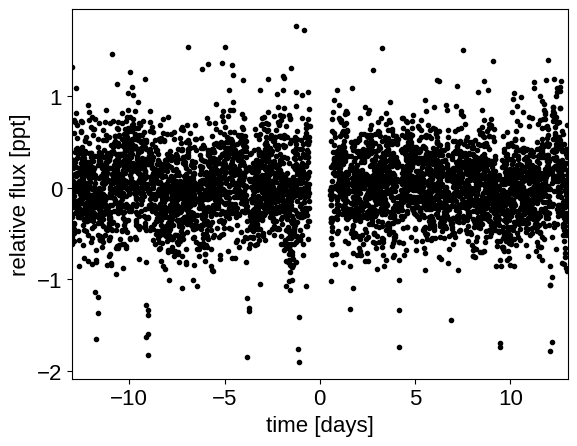

In [ ]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
from astropy.io import fits

lc_file = lk.search_lightcurve(
    "TIC 375506058", sector=15, mission="TESS"
).download(quality_bitmask="hardest", flux_column="pdcsap_flux")
lc = lc_file.remove_nans().normalize().remove_outliers()
time = lc.time.value
flux = lc.flux

# For the purposes of this example, we'll discard some of the data
m = (lc.quality == 0) & (
    np.random.default_rng(375506058).uniform(size=len(time)) < 0.3
)

with fits.open(lc_file.filename) as hdu:
    hdr = hdu[1].header

texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

ref_time = 0.5 * (np.min(time) + np.max(time))
x = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
y = np.ascontiguousarray(1e3 * (flux[m] - 1.0), dtype=np.float64)

plt.plot(x, y, ".k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.xlim(x.min(), x.max())

In [ ]:
pg = lc.normalize(unit='ppm').to_periodogram()
pg

LombScarglePeriodogram(ID: TIC 375506058)

**Box Least Square**

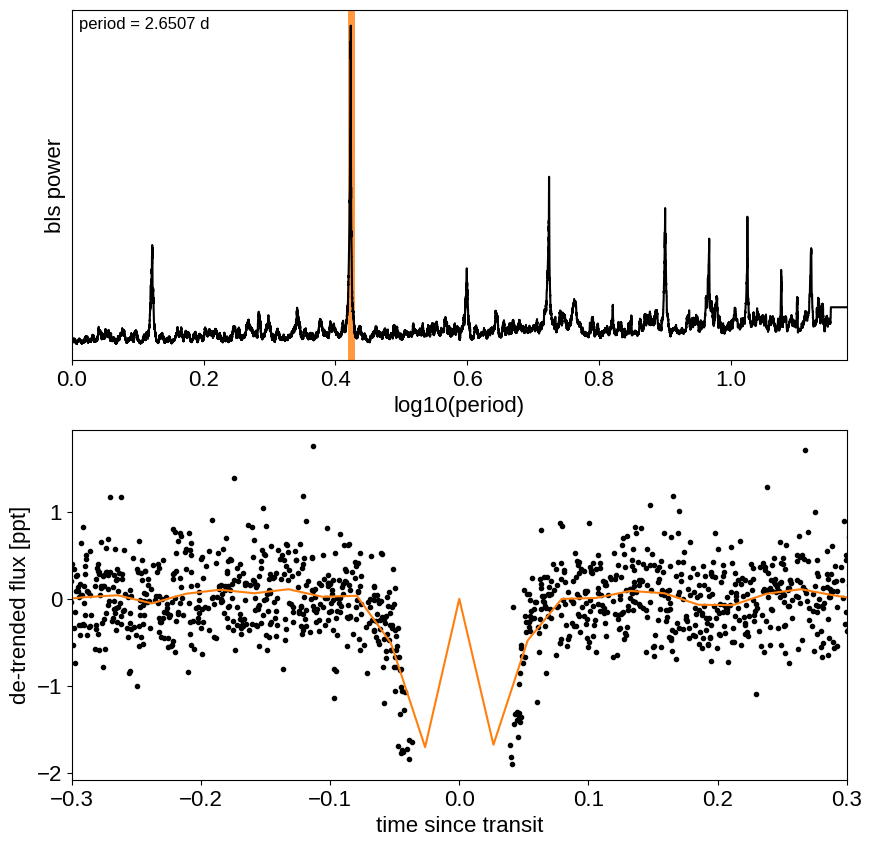

In [ ]:
from astropy.timeseries import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(x, y)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(x, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate(
    "period = {0:.4f} d".format(bls_period),
    (0, 1),
    xycoords="axes fraction",
    xytext=(5, -5),
    textcoords="offset points",
    va="top",
    ha="left",
    fontsize=12,
)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (x - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], y[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y)
denom[num == 0] = 1.0
ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
_ = ax.set_xlabel("time since transit")

**Lomb-Scargle**

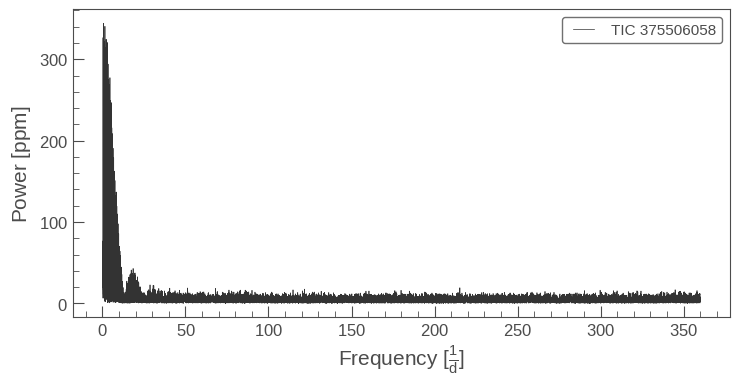

In [ ]:
pg.plot();

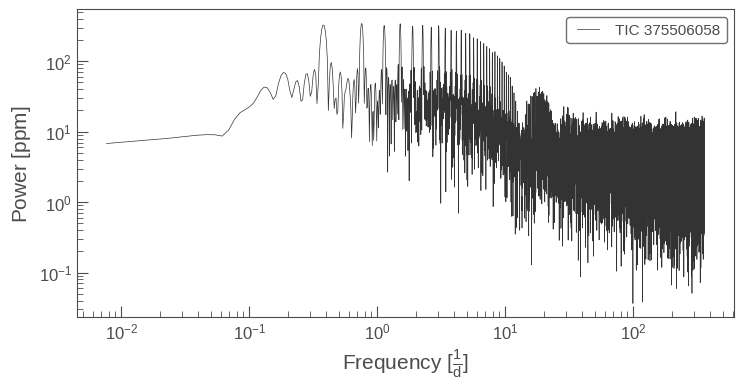

In [ ]:
pg.plot(scale='log');